# Diffusion math
This notebook provides bits and pieces of good insights to aid in understanding the math of diffusion models, in particular the math will be focused on [DDPM](https://arxiv.org/pdf/2006.11239) (Denoising diffusion probabilistic models).

In [2]:
import matplotlib.pyplot as plt
import numpy as np

## Prerequisites
General maturity in probability theory is good and basic familiarity with integrals. You don't necessarily need to know how to solve integrals, but be familiar with what they mean conceptually and how to interpret them. Otherwise, the really relevant concepts are
* Joint, conditional, marginal probability
* Expectation, variance, standard deviation, covariance
* Bayes' theorem
* Univariate and multivariate gaussian
* KL-divergence
* Information theory (self-information + entropy)
* Evidence lower bound (ELBO)
* Basic understanding of VAE helps alot since diffusion can be seen as an extension of VAE, but is not necessary

You can either google these or look at my notebooks for these concepts.
I cover the following concepts in [probability-fastai-probability-theory-concepts](probability-fastai-probability-theory-concepts.ipynb)
* Joint, conditional, marginal probability
* Expectation, variance, standard deviation, covariance
* Bayes' theorem
* Univariate and multivariate gaussian

And concepts below can be found in [probability-fastai-probabilistic-machine-learning-concepts](probability-fastai-probabilistic-machine-learning-concepts.ipynb)
* KL-divergence
* Information theory (self-information + entropy)
* Evidence lower bound (ELBO)

## Math techniques
These are techniques to be aware of when going through derivations of the diffusion math. I assume you already know the prequisites above, so I won't present any of those concepts here. The techniques presented in this section are complementary and are things you would see when reading diffusion math related to DDPM.

Outline of the subsections
* Log laws
* Random division fact
* Factoring out variables
* Foil rule
* Binomial squares
* Difference of squares
* Bayes' rule
* Expectation properties
* Introducing new variables to change expression
* Gaussian notation - variance vs standard deviation
* Gaussian shift and scale
* Multivariate gaussian with diagonal covariance matrix equivalent to independent random variables
* Conditional probability - plague
* Proportionality
* Integral properties
* Reparametrization
* Monte carlo
* Relations with noise
* Completing the square
* Quadratic formula linear algebra
* Data manifold

**Logarithm laws**
\
Log is standard to use when working with probabilities (avoids underflow, is monotonic and makes derivative easier to work with), therefore knowing about some of the log rules is important.

$$\log \dfrac{a}{b} = \log a - \log b$$
$$\log(a \cdot b) = \log a + \log b$$
$$\log_{e}e^a = \ln e^a = a$$

The rules are the same for the natural log called ln. Also, another log trick that is occasionally used to swap the order of the numerator with the denominator is

$$\log \dfrac{p}{q} = \log p - \log q = - (\log q - \log p) = - \log \dfrac{q}{p}$$

This happens sometimes in KL-divergence in the derivations. For instance, we can switch the numerator and the denominator like so

$$D_{KL}(p||q) = E_p\left[\log \dfrac{p}{q}\right] = \int_{-\infty}^{\infty} p(x) \log \dfrac{p(x)}{q(x)} \, dx = -\int_{-\infty}^{\infty} p(x) \log \dfrac{q(x)}{p(x)} \, dx$$

or in expectation

$$E_{q(x)}\left[\log \dfrac{p(x)}{q(x)}\right] = -E_{q(x)}\left[\log \dfrac{q(x)}{p(x)}\right] = - D_{KL}(q||p)$$

where in the last expression we have converted the expectation into a KL-divergence thanks to switching the numerator and the denominator.

**Very random division fact**
\
This comes up often in the diffusion a unified perspective 2022 paper, mostly because they want to be very explicit with every step, but you wouldn't usually see this in other papers because it would just be simplified.

$$\dfrac{a}{\left(\dfrac{b}{c}\right)} = \dfrac{ac}{b}$$

**Factoring out variables**
\
Very easy and common technique is to move variables outside an expression

$$\textcolor{green}{a}x + \textcolor{green}{a}b = \textcolor{green}{a}(x + b)$$

And this can manifest in so many different ways, but the idea is the same, which is if we can spot a variable occurring in all the terms in an expression, then we can for sure factor it out. Furthermore if we have multiple variables that occur in all terms then we can also factor them out, so it generalizes into something like this

$$\textcolor{green}{ac}x + \textcolor{green}{ac}b = \textcolor{green}{ac}(x + b)$$

If it doesn't occur in all the terms in the expression but in a handful, we can still choose to factor the variables out, but only from the handful of terms, if it proves to be useful later on. A more complicated example is

$$\textcolor{green}{a}c + \textcolor{green}{a}d + \textcolor{blue}{b}c + \textcolor{blue}{b}d = \textcolor{green}{a}\textcolor{red}{(c + d)} + \textcolor{blue}{b}\textcolor{red}{(c + d)} = (\textcolor{green}{a} + \textcolor{blue}{b})(\textcolor{red}{c + d})$$

**FOIL rule - First outer inner last**
\
Apparently this has a name called [FOIL rule](https://en.wikipedia.org/wiki/FOIL_method) and is a mnemonic for describing the process of multiplying two binomials. It's best visualized taken from wiki

![](assets/foil.png)

The way I think of it is to just multiply every term with the other terms in the parenthesis.

**Binomial squares**
\
Also common and something everyone has seen in high school

$$(x+y)^2 = x^2+2xy+y^2$$
$$(x-y)^2 = x^2-2xy+y^2$$

Notice that they only differ in the middle term by the sign. In order to derive the form just use the FOIL rule, but if you instead remember this exact form it will save you some time instead of having to add together the middle terms.
A more generalized form of this is called the [binomial theorem](https://en.wikipedia.org/wiki/Binomial_theorem#Statement) and is a general formula to compute the exact form up to a power of n (if n isn't too high you can use [Pascals triangle](https://en.wikipedia.org/wiki/Pascal%27s_triangle) to compute the coefficients for each term). But you rarely need more than power of 2. Furthermore, applying this to vectors instead looks almost the same, except we need to transpose one of the them to make it work (adhering to matrix multiplication convention, so shapes must be valid). Let u and v be vectors in $\mathbb{R}^d$ then we have

$$
\begin{align}
||u-v||^2 
&= (u - v)^T(u-v) \\
&= \left\{\text{Use FOIL rule}\right\} \\
&= u^Tu - u^Tv - v^Tu + v^Tv \\
&= \left\{\text{Use } u^Tv = v^Tu = \sum_{i=1}^d u_iv_i\right\} \\
&= ||u||^2 - 2u^Tv + ||v||^2
\end{align}
$$

Same idea if we had $||u+v||^2$, then the sign in the middle term changes to a plus sign. In the event that u and v are [orthogonal](https://en.wikipedia.org/wiki/Orthogonality) to each other, meaning they are perpendicular, then the middle term vanishes, and for the plus situation we get the [Pythagorean theorem](https://en.wikipedia.org/wiki/Pythagorean_theorem), where the vectors are interpreted as being the [cathetus](https://en.wikipedia.org/wiki/Cathetus) of a perpendicular triangle.
Let's use a similar but little bit harder example. Say we had the following shapes u as dxl, a as lx1, v as dxk and b as kx1, then using the formula we get
$$||ua-vb||^2 = ||ua||^2 - 2(ua)^T(vb) + ||vb||^2$$

Here the idea is even though some terms were matrices u and v, as long as we can get the two terms within the L2-norm to be vectors in the end ua and vb, then it's straightforward to use the formula.

**Difference of squares**
\
Similar to the above but we have instead for real numbers

$$(a-b)(a+b) = a^2 - b^2$$

And for vectors u and v

$$(u-v)^T(u+v) = u^Tu + u^Tv - v^Tu - v^Tv = ||u||^2 - ||v||^2$$

**Bayes' rule**
\
In diffusion Bayes' rule is used to flip the condition to compute the distribution for the backward process using the forward process.

$$q(x_{t-1}|x_t,x_0) = \dfrac{q(x_t|x_{t-1}, x_0)q(x_{t-1}|x_0)}{q(x_t|x_0)}$$

where $q(x_t|x_{t-1}, x_0)$ is the distribution for the forward process.

**Expectation properties**
\
The only relevant ones are

$$E[X + Y] = E[X] + E[Y]$$
$$E[X + k] = E[X] + k$$
$$E[aX + k] = aE[X] + k$$
$$E[aX + k + bY + l] = aE[X] + k + bE[Y] + l$$

where X and Y are random variables and a,k and l are constants. These are important because at times the derivations pushes the expectations out or into expressions. Furthermore, since the formula 

$$E[X] = \int_{-\infty}^{\infty}xp(x)\, dx$$

expects a distribution this means that when we are working with multiple variables usually we have to clarify in respect to what we are taking the expectation over otherwise it's ambiguous. For instance if we have

$$E[X,Y]$$

Then should we take the expectation over X or Y or both? It's not clear. However, we can partially solve this by specifying the variables we are interested in as a subscript to the expectation. There are different scenarios in this case that will in general give different results. If $x \sim p(x)$, $y \sim q(y)$ and $x,y \sim r(x,y)$ then we have

$$E_{X}[X,Y] = f(Y=y) = \int_{-\infty}^{\infty}xyp(x)\, dx = y\int_{-\infty}^{\infty}xp(x)\, dx = yE[X]$$
$$E_{Y}[X,Y] = f(X=x) = \int_{-\infty}^{\infty}xyq(y)\, dy = x\int_{-\infty}^{\infty}yq(y)\, dy = xE[Y]$$
$$E_{X,Y}[X,Y] = \int_{-\infty}^{\infty}\int_{-\infty}^{\infty}xyr(x,y)\, dxdy$$

However, according to [Alecos Papadopoulos](https://stats.stackexchange.com/a/72614) taking w.r.t to a random variable could also mean taking the conditional, which gives the conditional expectation like so for instance

$$E_{X}[X,Y] = f(X=x) = \int_{-\infty}^{\infty}xyp(y|x)\, dy = x\int_{-\infty}^{\infty}yp(y|x)\, dy = xE[Y|X]$$

So it can be confusing what is intended. However, I think the common interpretations are
* The conditional interpretation is **rare**, and it's **more common to denote the marginal** instead. If you want a conditional then you usually define it explicitly.
* When not specifying what variables to take expectation over at all, then mostly our distribution can be assumed to be a *joint* over all the variables

There are also different styles for the subscript, some may write it as for instance

$$E_{X \sim \mathcal{N}(\mu, \sigma)}$$

or 

$$E_{X \sim p(x)}$$

or with only the distribution (which you will often see in generative AI contexts)

$$E_{\textcolor{green}{q_{\phi}(z | x^{i})}}[\log p_{\theta}(x^{i}|z)] = \int_{\mathbb{R}^d}\textcolor{green}{q_{\phi}(z|x^{i})} \log p_{\theta}(x^{i}|z) \, dz$$

to denote a specific distribution that X comes from. Some may even denote a little x (sample from X), instead of X. So it can vary alot. The last expression says take the expectation w.r.t to $q_{\phi}(z | x^{i})$, and since z is a random variable $f(x^{i}, z, \theta) = \log p_{\theta}(x^{i}|z)$ is a function where the randomness is induced by the random variable z. In this case the distribution for $\log p_{\theta}(x^{i}|z)$ is $q_{\phi}(z | x^{i})$ and therefore applying the formula for expectation is the reason we get the above expression. The interpretation of this integral is that we are "averaging" out the randomness of the latent random variable z.

Regardless, the point is that the subscript in expectations serves to clarify what variables we are working with and or what distributions we are working with for those variables and usually should be clear from the context. Although, if the common interpretations don't seem to work when using the formulas, try to fall back on the alternative interpretations and if that still doesn't work then it's the fault of the author for not clarifying. At that point you will have no choice but to do some detective work and figure it out by yourself or ask the author if possible.

**Introducing new variables to change expression**
\
This is a very general mathematical trick that one uses only if they know beforehand what kind of final expression they desire. In ELBO for instance there are some tricks used by papers where they introduce a new variable in a way that doesn't affect the value of the original function/expression, but in doing so can now change the appearance of the expression to something that is closer to what they desire. For instance if we have a log marginal $\log p(x)$ then we can introduce a new term by multiplying it with 1

$$\log p(x) = \log p(x)\underbrace{\int q_{\phi}(z|x) \, dz}_{1}$$

where $q_{\phi}(z|x)$ is a valid probability density function, so it must sum up to 1.
Another example is multiplying the existing expression with a new term and then dividing with the new term. Because we introduce it and cancel it out then it's as if the original expression hasn't undergone any changes at all. Let our original expression be

$$E_{q_{\phi}(z|x)}\left[\log \dfrac{p(x,z)}{p(z|x)}\right]$$

And let's introduce $q_{\phi}(z|x)$ as an example

$$
\begin{align}
E_{q_{\phi}(z|x)}\left[\log \dfrac{p(x,z)\textcolor{green}{q_{\phi}(z|x)}}{p(z|x)\textcolor{green}{q_{\phi}(z|x)}}\right] 
&= E_{q_{\phi}(z|x)}\left[\log \dfrac{p(x,z)}{\textcolor{green}{q_{\phi}(z|x)}}\right] +  E_{q_{\phi}(z|x)}\left[\log \dfrac{\textcolor{green}{q_{\phi}(z|x)}}{p(z|x)}\right] \\
&= E_{q_{\phi}(z|x)}\left[\log \dfrac{p(x,z)}{q_{\phi}(z|x)}\right] + D_{KL}(q_{\phi}(z|x) || p(z|x))
\end{align}
$$

So we can see how we started from a seemingly arbitrary expected value and by introducing a new term changed the appearance of the original expression into a form we desired, being able to split up the expression into an expectation and a KL-divergence, without changing the original value. These are common tricks people use in ELBO. Note that it doesn't have to be these specific terms, rather the point is that one can introduce new terms, whatever it may be, in order to change the appearance of the expression, so long as it doesn't change the original value.

**Gaussian notation - variance vs standard deviation**
\
The variance or standard deviation part of the gaussian notation varies from author to author. Some write the variance, some write the standard deviation. An advice to spot which one is which, is usually to pay attention to anything that is set to the power of 2 will most likely be variance, whereas for standard deviation it's either no power meaning to the power of 1 or square root even. Here are some examples

* $\mathcal{N}(0, \sigma^2)$ meaning variance, where $\sigma$ usually denotes standard deviation
* $\mathcal{N}(0, \sigma)$ meaning standard deviation
* $\mathcal{N}(\sqrt{\alpha_t}x, \sqrt{1-\alpha_t}I)$ meaning $\sqrt{1-\alpha_t}I$ is the standard deviation, whereas $(1-\alpha_t)I$ is the variance for a multivariate gaussian. This is the forward process in diffusion by the way.

If you are wondering why there seems to be a relation between variance and standard deviation it's because the relation is

$$\text{standard deviation}^2 = \text{variance} \implies \sqrt{\text{variance}} = \text{standard deviation}$$

**Gaussian shift and scaling**
\
Recall that the formula for shifting and scaling a gaussian distribution is

$$Y = aX + b \sim \mathcal{N}(a\mu + b, |a|\sigma I)$$

where X is a random variable that is distributed by a standard gaussian distribution, that is $X \sim \mathcal{N}(0, I)$.
\
Shift means add with something and scaling means multiply with something.
This means that when you are shifting a gaussian distribution by b and the mean is $\mu$, then the result is $\mu + b$, while for scaling with a and if the standard deviation is $\sigma$ the result for the mean is $a\mu$ and for the standard deviation $|a|\sigma$. 
In the forward process a gaussian shift and scale occurs at each timestep. We have this general equation for computing a latent at any time step t

$$z_t = \sqrt{\alpha_t}x + \sqrt{1-\alpha_t}\epsilon$$

where $z_t$ is the latent variable (hidden), $\alpha_t = \Pi_{t=1}^{T}1-\beta_t$, $\beta_t \in [0, 1]$ and $\epsilon \sim \mathcal{N}(0, I)$. If we now use the formula for shifting and scaling a gaussian then this can be interpreted as scaling the gaussian noise $\epsilon$ by $1-\alpha_t$ on the variance ($\sqrt{1-\alpha_t}$ on the standard deviation) and shifting by $\sqrt{\alpha_t}x$ on the mean at each timestep t. Note that the scaling didn't affect the mean simply because the mean is zero, so multiplication has no effect on it. 

To help with visualizing scaling and shifting a gaussian let's look at this example where you shift the gaussian by k steps to the right in the x-axis. That's what happens when you shift by a positive k.

![](assets/shifting_gaussian.png)

Scaling is not as visually elegant as shifting, since you modify both the mean and the variance, but it's very straightforward to calculate the effect using the formula.

**Multivariate gaussian with diagonal covariance matrix equivalent to independent random variables**
\
Only for gaussian distribution does zero covariance imply independence. A diagonal covariance matrix means zero covariance, because the off-diagonals are zeros. This means that since we are working with multivariate gaussians in the forward process, where the covariance is a diagonal matrix for the gaussian noise we add to the latent variables, we can therefore interpret each entry in the 2D matrix of the noise $\epsilon$ as coming from their own univariate gaussian distribution. To see this I will refer to [cs229 from Stanford](https://cs229.stanford.edu/section/gaussians.pdf) section 3.   

**Conditional probability - plague**
\
Recall that conditional probability of two random variables can be written as

$$\dfrac{p(A,B)}{p(B)} = p(A|B)$$

If we condition the marginal $p(B)$ with a random variable C then we get

$$\dfrac{p(A,B|C)}{p(B|C)} = p(A|B,C) \iff p(A,B|C) = p(A|B,C)p(B|C)$$   

So the condition C infects the other expressions like a plague. Looking at the marginal $p(B)$ once conditioned on C $p(B|C)$ it means that if A is now conditioned on B then since B is conditioned on C they have to appear together in the conditional probability of A given B given C. So the conditional $p(A|B)$ changes to $p(A|B,C)$, so we condition on both now. Then using the joint formula when multiplying the two we finally get $p(A,B|C) = p(A|B,C)p(B|C)$. That's how I like to think of it.


**Proportionality**
\
Sometimes you will see this sign $\propto$, which just means that something is proportional to something else. $a \propto b$ means that a is proportional to b meaning $a = k \cdot b$ for some $k \in \mathbb{R}$. This is usually used in context of bayes' rule, where we ignore some parts of an expression, usually the normalizing constant. Therefore, we sometimes see something like $p(a|b) = \dfrac{p(b|a)p(a)}{p(b)} \propto p(b|a)p(a)$. The reason for this is the normalizing constant is usually intractable to compute for high dimensional data or complex expressions that don't have a closed-form solution, so instead we can simplify the computation by putting a proportional equality instead.

**Integral properties**
\
There are alot of properties, just listing the relevant ones
* $\int yf(x) \, dx = y\int f(x) \, dx$. This is because y is not dependent on any x, and since we integrate w.r.t to x then y is considered a constant that we can move outside
* $\int\int g(y)f(x) \, dxdy = \int g(y) \, dy \int f(x) \, dx$
* $\int yp(x) \, dx = y\int p(x) \, dx = y \cdot 1 = y$. This is if p(x) is a valid probability density function, so that it integrates to 1. This is usually used to marginalize out irrelevant variables that we don't need to consider, because the marginalization of proper distribution should give us an integral of 1, which means they will dissappear without affecting whatever is left.

**Reparametrization**
\
Reparametrization is a general term for anything where you "change" the parameters that a function is dependent on or that an expression contains. This can produce an entirely different expression, but the results should still remain the same, that is the range of the original function prior to being reparametrized has to be the same as after the reparametrization so that they describe the same graph or curve so to speak. The purpose of reparametrization is to put emphasis on different mathematical perspectives or make computation easier, because the new expression can be easier to work with in certain situations. For instance if we look at the famous unit circle equation

$$x^2+y^2=1$$

This is based on the euclidean pythagorean theorem. While this produces a unit circle it's not very pleasant to work with if we want to work with angles to describe x- and y-coordinates instead. Therefore, we can instead look to trigonometric functions, in particular cos and sin. How do we incorporate these into our original equation? We reparametrize it by substituting them into the original equation. We have these relations that we know from basic algebra

$$cos \theta = x$$
$$sin \theta = y$$

where $\theta \in [0, 2\pi]$ is the angle between the line from origo to the perimeter of the circle and the x-axis.
So after substitution we get

$$cos^2\theta + sin^2\theta = 1$$

And this is the unit circle once again, but reparametrized with $\theta$, so that it no longer depends on x and y. Why is this more useful? To name a few benefits, the equation now only depends on one variable so it's easier to describe lines within the circle if we want to extend it to arbitrary length radius r. It's easier to analyze since we don't have to look at the piecewise parts $y = \pm \sqrt{1 - x^2}$ anymore. Integration is easier as well as we don't need double integration now that we only have one variable. Alot of phenomenon in nature and physics can be naturally described with trigonometric functions such as harmonic motions, waveforms etc, so it makes it more suitable to work with trigonometric expressions. I will show you later on how the reparametrizations are used in diffusion, but this section is to show the easy idea of what reparametrization is and what one possible reparametrization could look like and why we would want to do it. Below is simple illustration of a unit circle, blue represents the reparametrized function of a unit circle with $\theta$ and the red is the one with x and y.


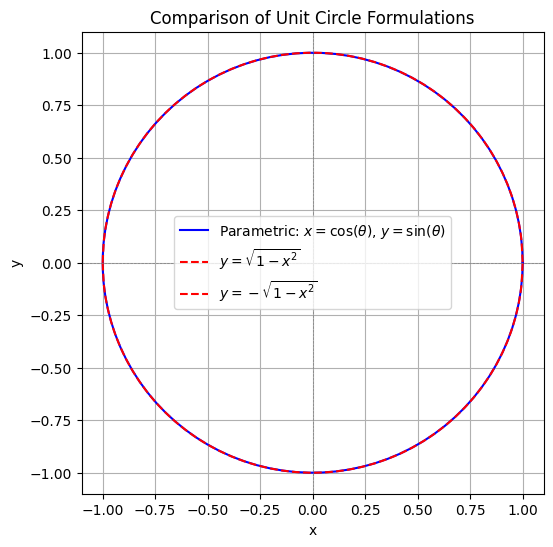

In [3]:
# Define the angle range for the parametric circle
theta = np.linspace(0, 2 * np.pi, 100)

# Parametric formulation of the unit circle
x_parametric = np.cos(theta)
y_parametric = np.sin(theta)

# x^2 + y^2 = 1 formulation
x_standard = np.linspace(-1, 1, 400)
y_positive = np.sqrt(1 - x_standard**2)
y_negative = -np.sqrt(1 - x_standard**2)

# Create the plot
plt.figure(figsize=(6, 6))

# Plot the parametric unit circle
plt.plot(x_parametric, y_parametric, label='Parametric: $x = \cos(\\theta)$, $y = \sin(\\theta)$', color='blue')

# Plot the standard unit circle
plt.plot(x_standard, y_positive, label='$y = \sqrt{1 - x^2}$', color='red', linestyle='dashed')
plt.plot(x_standard, y_negative, label='$y = -\sqrt{1 - x^2}$', color='red', linestyle='dashed')

# Formatting the plot
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Comparison of Unit Circle Formulations')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

**Monte carlo**
\
The point of Monte Carlo in diffusion usually is to approximate the integral of something that can't be solved analytically or is intractable. The integral arises because of expectation of random variables with continuous values as it's domain. Specifically with Monte Carlo we can approximate the expectation with the sample mean

$$E_{x \sim p}[f(x)] = \int_x f(x) p(x) \, dx \approx \dfrac{1}{N}\sum_{n=1}^{N}f(x^{n})$$

One can show that the MC is an unbiased estimator and if the variance is finite then it will decrease monotonically as the number of samples N increases. Specifically in diffusion, for the noise formulation, in theory MC is used to approximate the reconstruction term that is the term for going from time $t=1$ to $t=0$ which can be described as $q(x|z_1)$, much like how it's used in VAE. However, [Luo](https://arxiv.org/pdf/2208.11970) seems to disregard the term entirely, while [Prince chapter 18](https://udlbook.github.io/udlbook/) shows how this term can be merged into the backward posterior (the main term we want the model to learn) in equation 18.38 page 362, so we don't need to bother with MC, because we just use the formula for [KL divergence between two multivariate gaussians](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Multivariate_normal_distributions) on the main term, so we can compute it in closed-form. If this is unclear look at equation 58 and 86 in the [Luo](https://arxiv.org/pdf/2208.11970) paper, specifically the denoising matching term in 58. It can be written as

$$\sum_{t=2}^T E_{q(x_1|x_0)}\left[D_{KL}(q(x_{t-1}|x_t,x_0)||p_{\theta}(x_{t-1}|x_t))\right]$$

 So in the end we don't directly use any MC on the relevant terms, but some form of MC is still carried out I think. The timesteps almost seems MC because of the randomness introduced, but since we are not summing over anything and weighting it for the timesteps, then I don't think it is MC. Furthermore, one could argue that the mini-batch approach in mini-batch GD, where you randomly sample a batch from the training, can be seen as using MC, because the loss function over the training data can be written as an expectation and then using MC to approximate this expectation would result in the mini-batch approach. But this would then be true for all neural networks that use mini-batch GD to train it. However, as far as using MC on the original expectation over the denoising matching term, this is not done as far as I'm concerned.

**Specific relations with noise**
\
Remember that the general noise formula at time t is 

$$\alpha_t = \Pi_{t=1}^T 1-\beta_t = (1 - \beta_1)...(1 - \beta_t)$$

where $\beta_t \in [0,1]$. Based on this formula we therefore have useful relations such as these

$$(1 - \beta_t) * \alpha_{t-1} = (1-\beta_1)...(1-\beta_{t-1}) \cdot (1-\beta_t) = \alpha_t$$
$$\dfrac{\alpha_t}{1-\beta_t} = \alpha_{t-1}$$

Both are used in Prince chapter 18 and the 2022 paper diffusion a unified perspective.

**Completing the square**
\
[Wikipedia](https://en.wikipedia.org/wiki/Completing_the_square) has another form for completing the square. I just think of it in simpler terms. We have an expression with one quadratic term and the rest of the terms are either something that looks like a cross-term and or constants. What we would like to achieve is to put them into one quadratic term and whatever is remaining is put into some constant c.

$$x^2 + 2xy + k = (x + y)^2 - y^2 + k = (x+y)^2 + c$$

where $c = -y^2 + k$. This is usually used to "pattern match" an expression that we are interested in. In diffusion it's mostly for the quadratic term in gaussian distribution $-\dfrac{1}{2}\dfrac{(x - \mu)^2}{\sigma^2}$, but we are only interested in the numerator. Let's say we have an expression like this

$$-\dfrac{1}{2\sigma^2}\left[\textcolor{green}{x^2 - 2xy}\right]$$

then trying to pattern match the green part within the square brackets with the quadratic term (because they look almost identical) in a gaussian distribution gives us

$$\left[x^2 - 2xy\right] = \left[x - y\right]^2 - y^2 \stackrel{+}{=} \left[x - \underbrace{y}_{\mu}\right]^2$$

where we ignore the rest term $y^2$. The $\stackrel{+}{=}$ is an additive equality, which means they are equal up to an additive constant, so they are only different by some constant you add together. In this case the only difference between the two was $-y^2$, but by using this notation we can therefore ignore the $-y^2$, and therefore perfectly pattern match with the quadratic term of the gaussian distribution. Obviously one has to note that once we go down this route of using additive equality or proportional equality, then we aren't computing the same thing anymore, and therefore only working with an **approximation**. We can see from this that the $\mu$, which is the mean of the gaussian, constitutes whatever $y$ is. This is a very simple example of how to pattern match things in math and completing the square is one tool to achieve this when we are working with quadratic terms.

**Quadratic form with diagonal matrix - linear algebra**
\
This is a special case of the [quadratic form](https://en.wikipedia.org/wiki/Quadratic_form#Associated_symmetric_matrix) you would usually encounter in linear algebra

$$x^T M^{-1} x$$

where x is a column vector 1xD, $x^T$ is a row vector Dx1 and M a DxD diagonal matrix. Remember that the inverse of a diagonal matrix is just the reciprocal of each diagonal elements. What's so special with diagonal matrix is that the off-diagonals are zero and if the variances at the diagonals are the same, then we can see that we get

$$\dfrac{1}{\sigma^2}||x||_2^2$$

I'm not going to provide the proof, but it's very simple and I encourage the curious reader to try it themselves, the key lies in that you are doing matrix multiplications with a diagonal matrix, so the off-diagonals will cancel out alot of possible entries in the result, and the fact that the diagonals are assumed to be the same means we can factor out the value. The use of this in diffusion is when you apply the formula for [KL-divergence between two gaussian distributions](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Multivariate_normal_distributions), where we assume the covariance matrix of each gaussian to be diagonal and the variances are the same for their respective diagonals.

**Data manifold**
\
I don't quite understand this myself, because a technical definition of manifolds require knowledge in [topology](https://en.wikipedia.org/wiki/Topology), which is advanced math. I will however add my understanding of it here, because it seems to be mentioned from time to time, without any explanations. [Wiki](https://en.wikipedia.org/wiki/Manifold) says the following about manifold
> In mathematics, a manifold is a [topological space](https://en.wikipedia.org/wiki/Topological_space) that **locally resembles Euclidean space** near each point. 

For instance, the planet earth is a good example of a manifold, for us humans when we are walking on the surface of the planet it comes across as being flat (we are locally moving along the surface of the manifold), but the planet itself is really just a sphere. In a sense it's a 2D manifold embedded into a 3D space, because we can think of charting these flat surfaces of the planet and putting them together, it would be almost like unrolling the sphere into a 2D map. But in doing so, we have now transformed the 3D sphere into a set of 2D charts. In machine learning context this means that we could perhaps describe this 3D sphere with less variables than originally presented, effectively reducing the dimensionality. And this idea that most high-dimensional data lies on a lower dimensional manifold is called [manifold hypothesis](https://en.wikipedia.org/wiki/Manifold_hypothesis) and is the reason why we try to perform dimensionality reduction on high-dimensional data to begin with. In the case of diffusion we are just saying that the image dataset lies on a lower-dimensional manifold that we are trying to learn to represent with our model.

Just for illustration of unrolling a manifold, let's consider a swiss roll like the image below in 3D space. Clearly this seems to have some 2D structure. If we unroll this structure we get something in 2D space instead, which shows that we could describe this 3D object as a lower-dimensional manifold with fewer variables in 2D.

![](./assets/swiss_roll_manifold.png)
![](./assets/unrolling_swiss_roll_manifold.png)

## Diffusion informal walkthrough - noise formulation
This section focuses more on the intuition rather than the rigorous parts of diffusion. The purpose is to tie together insights that we have collected as a group about diffusion into a coherent walkthrough.

**Outline**
* Intro
* Assumptions, data format and preprocessing
* Forward process
* Loss function
* Training
* Backward process

### Intro
Imagine we have an image dataset and we want to train a model to generate samples that are representative of the data images. How do we do it? There are lots of different methods nowadays, and they come with different flavours. I'm not going to cover any of the other methods, as I quite frankly don't remember them well enough to even provide a brief description, but I will include two images that shows a nice comparison of diffusion models and some of the other methods that are popular.

![](assets/advantage_genai_models.png)

This shows that diffusion models cover two of the features, high quality samples and mode coverage/diversity, while being slower to sample compared to GANs, VAEs and models using normalizing flows. The slower sampling has to do with the backward process in DDPM being markovian, thus not able to jump time steps and needing a large number of steps to converge to a clean image (hundreds to thousand for DDPM). The [DDIM](https://arxiv.org/pdf/2010.02502) paper however seems to speed this up by instead working with a non-markovian structure for the backward process, thus being able to jump time steps. There are other papers since DDPM and DDIM that has tried to improve the speed of sampling ($\textcolor{red}{\text{Insert popular references}}$). We also have this nice table to show general comparisons between them.

![](assets/genai_models_table_features.png)

Here likelihood basically means whether computing the likelihood p(x) for any given **data point** x is exact or not. Diffusion models only do this approximately. Also reconstruction is hard for a diffusion model since the diffusion paths vary alot even from the same starting point, so it's never guaranteed that you would end up with the exact same image starting from the exact same noise. As for the bottleneck the dimension is the same for input and output, so it never changes throughout the process, unlike VAE that has a bottleneck between the encoder and decoder after the dimensionality has been reduced. The mode covering/diversity feature of diffusion models is thanks to a multitude of noise sources (including the scheduler) and stochasticity being introduced during the forward and backward process. This has a positive effect on preventing mode collapse, since areas with low probability density in the data space will be assigned more probability or be explored more in the diffusion paths.  Also the training objective is a minimization of a KL-divergence that is a M-projection (forward KL-divergence) $D_{KL}(\text{true distribution} || \text{approximate distribution})$, meaning it's mode covering to begin with. 

One thing to note about diffusion models is that while it takes inspiration from bayesian approaches, since it's a markovian hierarchical VAE, and VAEs are bayesian (they use a form of variational inference), it doesn't **directly** use any bayesian, MLE or MAP. It's not MLE because we aren't optimizing directly on the likelihood $P(D|\theta)$. It's not MAP, because we aren't using any priors directly in the optimization. The standard gaussian at the end of T can be seen as some kind of prior in the forward process, but it's not being used as a weighting on all terms in the optimization as you would in MAP $\operatorname*{argmax}_{\theta} P(D|\theta)\textcolor{green}{P(\theta)}$. It's not VI because we aren't computing $P(z|x)$ (we have the diffusion kernel for that which is not learnt), where z is a latent and x is the data, which is what VI and the encoder in VAE does. Instead, and as you will see later on in the loss section, we are trying to compute $q_{\theta}(x_{t-1}|x_t)$ that is the posterior in the backward process and the form can be derived by using Bayes' rule.

Anyways, since this notebook is about diffusion the following sections will give intuition on how diffusion in DDPM works. The brief overview is that even for diffusion models there are different formulations one can go with that leads to different loss functions for diffusion and in this section we go with the noise formulation, where the model has to learn the noise in a noisy image. This formulation seems to be the most popular on the internet when covering the basics of diffusion, mostly because the [original stable diffusion](https://arxiv.org/pdf/2112.10752), [GLIDE](https://arxiv.org/pdf/2112.10741) and [DALL-E 2](https://arxiv.org/pdf/2204.06125v1) used it.


### Assumptions, data format and preprocessing
Assumptions
* Data is i.i.d, meaning each sample comes from the same distribution and are independent. We call this distribution the data distribution $p(x)$.
* Forward and backward process follows a markov chain, i.e next latent is only dependent on previous latent
* Latent dimension and data dimension are equal throughout the forward and backward process
* Distribution of intermediate latents in the forward are gaussians, these gaussians are not learnt. This means the encoder part of diffusion is never learnt, it's pre-defined as gaussians together with a scheduler. 
* Distribution of latent at the end of forward process converges to standard gaussian when timesteps $t \to \infty$

Data format is 2D images but with color channel (greyscale only has 1 color channel) becomes 3D. With a batch this can even go to 4D. But in the formulas we are usually only thinking of a single image at a time, and that image is percieved as 2D I think, even though in practise it's 3D because of color channels. These are not flattened as in VAE, where we would have a 1D array. The preprocessing step in DDPM seems to be to transform the image data from discrete pixel values $\{0,.., 255\}$ to continuous values $[-1,1]$. Note that as a natural consequence of how we define the forward process, the backward process will also be gaussian. Now whether you learn this distribution will depend on what formulation you choose, we will cover this in the loss section.

### Forward process
**Idea of forward process**
\
The idea of the forward process is usually described as starting with a clean image and destroying it through a series of noisifying steps, where gaussian noise is added to it. Note that for the entire forward process we are only working with continuous values for the data and the noise. How much noise is added at each time step is decided by the scheduler that varies as a variable $\beta \in [0,1]$. It starts off from 0 and increases gradually to 1. The purpose is to eventually reach a state where the image becomes random noise distributed by a standard gaussian $N(0,I)$. For the DDPM they used a linear scheduler starting from $\beta_1 = 10^{-4}$ to $\beta_T = 0.02$. We call each intermediate noisy image a latent. Mathehmatically this process is characterized as a Markov chain, where each latent is only dependent on the previous latent. Illustration of this

![](assets/forward_process.png)

As can be seen each latent is generated only depending on the previous latent. This is the markovian structure for diffusion. And as time goes, the original image gets more noisy.

**Diffusion kernel - jump steps**
\
However, to make it more efficient, one can bypass this restriction of having to go one step at a time, by using the diffusion kernel to immediately jump to the latent at timestep t, which makes it more efficient to sample latents. The diffusion kernel is an important part of the diffusion process and can be described as 

$$x_t = \sqrt{\alpha_t}x_0 + \sqrt{1 - \alpha_t}\epsilon$$

where $x_t$ is the latent variable (hidden), $\alpha_t = \Pi_{t=1}^{T}1-\beta_t$, $\beta_t \in [0, 1]$ and $\epsilon \sim \mathcal{N}(0, I)$. In general $\alpha_t \to 0$, $1-\alpha_t \to 1$ and $\beta_t \to 1$ as $t \to T$, where $\beta_t$ starts from 0. Alternatively one can describe it as a conditional gaussian distribution

$$x_t \sim q(x_t | x_0) = \mathcal{N}(\sqrt{1 - \alpha_t}x_0, \sqrt{1 - \alpha_t}I)$$

There is a dual interpretation of diffusion kernel as far as I'm concerned 
1. It's a gaussian shift and scaling, since we are adding $\sqrt{\alpha_t}x_0$ to the noise that comes from a standard gaussian distribution and scaling it by $\sqrt{1 - \alpha_t}$. This also means that the starting image $x_0$ heavily affects the possible positions for the latent $x_t$, which is natural, because the clean image is used as a starting point to add noise to.
2. Scaling the image down and adding noise to it, this is probably the most common interpretation on the internet, at least in introductory blogs/videos about diffusion.

Note that the diffusion kernel is not learned, it is completly pre-determined given an image $x_0$ and a scheduler. 
Furthermore, if one views the $x_0$ as a random variable distributed by the data distribution, then we can interpret it together with the forward process as gradually transforming a very complex data distribution into a gaussian distribution. Another way of looking at it is to say that the data is transformed from in-distribution to out-distribution, where the in-distribution is the data distribution of the images and out-distribution is anything outside the data distribution, basically meaning that the noisy image is no longer in the data manifold.

![](assets/in_and_out_dist.png)

If we assume the circle to be the data distribution, then adding noise to an image will bring it outside.

**Why scale the image down?**
\
One might wonder where the scalars $\sqrt{\alpha_t}$ and $\sqrt{1-\alpha_t}$ come from in the diffusion kernel. $\sqrt{1-\alpha_t}$ is for scaling up the variance and [Chan](https://arxiv.org/pdf/2403.18103) shows that when $t \to \infty$ then in the limit in order for the variance of the gaussian distribution to be I the scalar has to be precisely $\sqrt{1-\alpha_t}$, but the $\sqrt{\alpha_t}$ is not explained at all and comes out of nowhere. From what I've seen it should have a variance preserving purpose, to not make the variance explode, but I don't understand it myself. The simplest explanation though is that we want the mean to converge to zero at the end of the forward process, so that's why we need to scale the image down in the diffusion kernel. However, this doesn't still explain why specifically it has to be $\sqrt{\alpha_t}$, because it could have been any scalar that can scale down the image. This remains a mystery for now. Ideally a proof would be nice to see.

**Shape of noise**
\
The shape of the noise is the same as the data, which is 3D. Because we are actually working with multivariate gaussians and the noise is sampled from a standard gaussian with a diagonal covariance matrix, this means that each entry in the 3D shaped noise array can be seen as being sampled from their own univariate gaussian distributions. And after scaling this noise and adding it to the clean image, we can interpret that as we are adding each pixel of the image with noise, where each noise element in the 3D array comes from their own univariate gaussian distribution. Once again, the intuition for why zero covariance (diagonal covariance matrix) implies zero independence only for gaussians can be found in the [cs229 stanford](https://cs229.stanford.edu/notes-spring2019/cs229-notes2.pdf) section 3.

**Why does forward process work?**
\
Intuitively it's a much harder task to go from pure noise to a clean image in one step. Going one step at a time with smaller adjustments to the clean image by adding noise to it, will only change the distribution slightly, whether it's marginal $p(x_t)$ or conditional $p(z_t|z_{t-1})$. The change is much easier to learn than the change from pure noise to data distribution, because each intermediate distribution is similar to the previous one.

**Marginal vs conditional**

> I'm not sure about this particular subsection. Needs to be revised!!!

Earlier we had some discussions on the difference between the marginal and the conditional of the latents. The marginal was brought up, because [Prince chapter 18](https://udlbook.github.io/udlbook/) had visualized the marginals in the forward process. We came to the conclusion that the marginal $q(x_t)$ can be seen as representing the average bluriness in the image at time t, while the conditional $q(z_t|x)$ that is the diffusion kernel, can be seen as the bluriness for a given image x. For the marginal case I think this can be made clearer by observing the following expression

$$E_{p(x)}\left[q(x_t|x)\right] = \int q(x_t|x)p(x) \, dx = \int q(x_t,x) \, dx = q(x_t)$$

where the integral is taken over all possible x, meaning all possible data points. This basically says to compute the average of the latent $x_t$ conditioned on x where x comes from the data distribution. So it's the average bluriness in the image at time t.
However, note that this marginal is different from the marginal likelihood that is the data distribution. This only concerns with the latents and this can be seen if we just look at how it's computed

$$q(x_t) = \int_x q(x_t|x)p(x) \, dx$$

where $q(x_t | x)$ is the diffusion kernel and $p(x)$ is the data distribution, whereas for the marginal data distribution we have

$$p(x) = \int q(x_T) \Pi_{t=1}^T q_{\theta}(x_{t-1} | x_t) \, dx_{1:T} = \int q(x_{0:T}) \, dx_{1:T}$$

so it should be clear that they are not the same? 

**Forward process in practise**
\
While many sources on the web make diffusion out to be this markovian chain, where one step is taken at a time to generate the next latent. In practise, the only time the forward process comes into play is during training, but even then it's different. Time steps are uniformly sampled, so we never sequentially iterate from 1 to T. Why sample time steps? No idea, heard it has a regularizing effect and perhaps it relates to Monte carlo, but not sure.

**Latent diffusion model**
\
Lastly, since this has been brought up in the group multiple times, the biggest difference between latent diffusion models such as stable diffusion and DDPM is that there's a VAE before training to downsample the image latent to lower dimensions, which makes it faster to train and infer. After sampling the latents are upsampled to the original image resolution.

### Loss function - noise and other formulations
\
Deriving the loss function is the hardest part of the theoretical side of diffusion, at least DDPM diffusion. There's alot of algebraic manipulations and mathematical tricks applied. I won't derive anything here, read the suggested papers in the next section if you want to see full derivations. Let's start with the log likelihood data $p(x)$. Because integrating out all the possible latents is intractable we can instead with clever manipulations arrive at the ELBO. Our job is to maximize this ELBO, so we can approach the data log likelihood $\log p(x)$, we want it as close as possible, because if we can train a model to approximate it well, then samples drawn from it will be representative of the data distribution.

$$\log p(x) \geq \underbrace{\underbrace{E_{q(x_1|x_0)}\left[\log p_{\theta}(x_0|x_1)\right]}_{\text{reconstruction term}} - \underbrace{D_{KL}(q(x_T | x_0) || p(x_T))}_{\text{prior matching term}} - \underbrace{\sum_{t=2}^T D_KL(q(x_{t-1}|x_t,x_0)  || p_theta(x_{t-1} | x_t))}_{\text{denoising matching term}}}_{\text{ELBO}}$$

where the reconstruction term is the same as in VAE and can be approximated with Monte carlo. However, later on this term can be ignored because it's very similar to $x_0$ if you can make the scheduler have a small gap between timestep 0 and 1, but an alternative explanation that I like better is given by Prince, where he shows that you can merge this term together with the denoising matching term. The prior matching term is zero under the assumption that our prior is the standard gaussian, so we can get an exact match. As for the denoising matching term this needs to be massaged a bit more before one can turn it into a loss function. Clever use of Bayes' rule on the backward distribution and [KL-divergence for two multivariate gaussians](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Multivariate_normal_distributions) gives the posterior for the backward process distribution

$$q(x_{t-1}|x_t) \sim \mathcal{N}\left(\underbrace{\dfrac{\sqrt{\alpha_t}(1-\alpha_{t-1})x_t + \sqrt{\alpha_{t-1}}(1-\alpha_t)\textcolor{green}{x_0}}{1-\alpha_t}}_{\mu_q(x_t, x_0)}, \underbrace{\dfrac{(1-\alpha_t)(1-\alpha_{t-1})}{1-\alpha_t}I}_{\sum_q(t)}\right)$$

Now the biggest take-away from [Luo 2022](https://arxiv.org/pdf/2208.11970) is that at this point reparametrizing $\textcolor{green}{x_0}$ in the mean of this posterior backward distribution will give different objectives/formulations of diffusion, basically resulting in different loss functions for diffusion. To get the noise formulation we need to isolate $x_0$ in the diffusion kernel and substitute the expression into the mean. Simplifying the resulting expression and substituting that into the denoising matching term and applying [KL-divergence for two multivariate gaussians](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Multivariate_normal_distributions) gives the final squared l2 distance of the noise differences giving the following objective 

$$\operatorname*{argmin}_{\theta} ||\epsilon_0 - \epsilon_{\theta}(x_t, t)||_2^2$$

There is some scaling factor that comes with it as well, but it's ignored to reweight the ELBO. This in combination with the training setup in DDPM leads to down-weighting the earlier timesteps where the noise is small between the steps to make the model focus on harder denoising tasks in later timesteps. In addition to the noise formulation one can reparametrize the mean into 3 additional objectives, which all differ up to a scaling factor.
1. Predict the original image given noisy image at time t
2. Predict the mean of the backward posterior distribution $q(x_{x-1}|x_t)$
3. Predict the score function

It's interesting to note that for the noise formulation we are using the mean of the backward posterior distribution as a **proxy** to learn the noise by reparametrizing the mean with $\epsilon_0$ through $x_0$, but in the end what we end up learning is to predict the noise in a noisy image and not the mean of the posterior backward distribution. Furthermore, one could decide to learn the variance by formulating it as of the posterior backward distribution, but DDPM found that gave unstable training and poorer sample quality, so they opted for fixed variances decided by the scheduler.

### Training
\
The algorithm for training is straightforward and note that it is the weights of the U-net that are being trained. U-net with self attention is used.

![](assets/training_diffusion.png)

Time is uniformly sampled and each time step doesn't have any weighting, meaning each time step is equally as important. T is set to 1000. [Katherine Crowson](https://github.com/crowsonkb) recommends to use bigger batch sizes when training diffusion models, usually 512 or higher, and the reasoning is because the inherent noisy process renders gradients generally noisy as well, so to combat this a bigger batch size is desirable. This is unsupervised, so no labels are needed and the ground truth is instead the sampled standard gaussian noise at time t. In a sense training the model in the forward process is teaching it to denoise, because noisy_image - noise = clean_image. Lastly, because of noise perturbation to the data, this can be seen as a form of data augmentation, since each data with perturbed noise is a slightly new kind of data point.

### Backward process
\
Unlike the forward process where we could just use the diffusion kernel to jump t steps, in the backward process we are stuck with the markovian structure. So we need to go one step at a time denoising the sampled standard gaussian noise until we get a clean image. This process is the inference step and therefore the sampling process, where we use our trained model to predict the noise at time t given a noisy latent. The process can be described in the following image.

![](assets/backward_process.png)

The backward distribution can be derived with Bayes' rule to be a gaussian.

$$q(x_{t-1}|x_t, x_0) = \dfrac{q(x_t | x_{t-1}, x_0)q(x_{t-1} | x_0)}{q(x_t | x_0)} \propto \mathcal{N}\left(\underbrace{\dfrac{\sqrt{\alpha_t}(1-\alpha_{t-1})x_t + \sqrt{\alpha_{t-1}}(1-\alpha_t)x_0}{1-\alpha_t}}_{\mu_q(x_t, x_0)}, \underbrace{\dfrac{(1-\alpha_t)(1-\alpha_{t-1})}{1-\alpha_t}I}_{\sum_q(t)}\right)$$


* backward process => move back from out-distribution to in-distribution
* backward process when doing sampling everytime is seen as a decision point where you can go from one mode to another (seems to align with score-based formulation)
* Diffusion paths, lots of possible latents can pass through a point in the diffusion path
* diffusion backward scheduler only takes a small proportion of the predicted noise, so we can move slowly from T to t=0. Each timestep will produce a latent that is slowly denoised
* Reverse process continuous but has to convert to discrete before reaching the image x_0, because pixels in an image are discrete, not continuous
* Sampler and scheduler is different! Some people use them interchangeably but they are not the same thing!
* Backward process mathematically can be seen as sampling $x_{t-1}$ from $q_{\theta}(x_{t-1}|x_t)$, that is $x_{t-1} \sim q_{\theta}(x_{t-1}|x_t)$.
* Markov chain is not bypassed in the backward process, so we need to go step by step until we get a clean image.

**Conclusion**
So just to recape, we have done...


## Formal walkthrough
After giving this section some thought, I don't think I'm able to provide anything of value than what hasn't already been shown in other papers and books. There are three good papers and a book on the diffusion math that covers it from scratch
1. [Understanding Diffusion Models: A Unified Perspective](https://arxiv.org/pdf/2208.11970). I like this one alot because it shows literally all the derivation steps. It also shows different objectives of diffusion that all are equal up to a scaling factor. The objectives are mean of posterior for the reverse process, noise in images in the forward process, original image $x_0$ given arbitrary latent $x_t$ and the score function.
2. [Tutorial on Diffusion Models for Imaging and Vision](https://arxiv.org/pdf/2403.18103). Also from scratch, but elaborates on the score function formulation more so than the paper above. Also goes into ODE and SDE of diffusion.
3. [Step-by-Step Diffusion: An Elementary Tutorial](https://arxiv.org/pdf/2406.08929). Also from scratch, but covers it from a different perspective. Covers DDPM and DDIM. Also covers flow matching, which is a neat technique to know since stable diffusion 3 uses it.
4. [Understanding deep learning](https://udlbook.github.io/udlbook/). Chapter 18 covers diffusion models, specifically DDPM using the noise objective, i.e. model learns to predict the noise added to latents. Good breakdown, although two of the formulas used, change of variable in gaussian and product of two gaussians, can feel a bit mysterious. The first paper listed here does give a good derivation of product of two gaussians without using the formula for product of two gaussians, so look at the paper if it's not clear.
5. [Original DDPM paper](https://arxiv.org/pdf/2006.11239). Then of course reading the original paper is always good, although they don't usually have the space to explain all the steps or show all the derivations, so it's usually more compressed.